“Modern Portfolio Theory (MPT), a hypothesis put forth by Harry Markowitz in his paper “Portfolio Selection,” (published in 1952 by the Journal of Finance) is an investment theory based on the idea that risk-averse investors can construct portfolios to optimize or maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of higher reward. It is one of the most important and influential economic theories dealing with finance and investment.

## Monte Carlo Simulation for Optimization Search


We could randomly try to find the optimal portfolio balance using Monte Carlo simulation

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
aapl = pd.DataFrame(wb.DataReader('AAPL','yahoo', '2012-1-1','2017-1-1')['Adj Close'])
cisco = pd.DataFrame(wb.DataReader('CSCO','yahoo', '2012-1-1','2017-1-1')['Adj Close'])
ibm = pd.DataFrame(wb.DataReader('IBM','yahoo', '2012-1-1','2017-1-1')['Adj Close'])
amzn = pd.DataFrame(wb.DataReader('AMZN','yahoo', '2012-1-1','2017-1-1')['Adj Close'])

In [4]:
stocks = pd.concat([aapl,cisco,ibm,amzn],axis=1)
stocks.columns = ['aapl','cisco','ibm','amzn']
stocks.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,51.464207,14.946354,144.750931,179.029999
2012-01-04,51.740776,15.235171,144.160431,177.509995
2012-01-05,52.315197,15.179017,143.476715,177.610001
2012-01-06,52.862103,15.122859,141.829529,182.610001
2012-01-09,52.778248,15.219128,141.091370,178.559998


In [6]:
stocks.pct_change(1).mean()

aapl     0.000750
cisco    0.000599
ibm      0.000094
amzn     0.001328
dtype: float64

In [7]:
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.302071,0.297770,0.235723
cisco,0.302071,1.000000,0.423887,0.284915
ibm,0.297770,0.423887,1.000000,0.259080
amzn,0.235723,0.284915,0.259080,1.000000


## Log Returns vs Arithmetic Returns

We will now switch over to using log returns instead of arithmetic returns, for many of our use cases they are almost the same,but most technical analyses require detrending/normalizing the time series and using log returns is a nice way to do that.
Log returns are convenient to work with in many of the algorithms we will encounter.

For a full analysis of why we use log returns, check [this great article](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).


In [8]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001588,0.006346,-0.005218,-0.022428


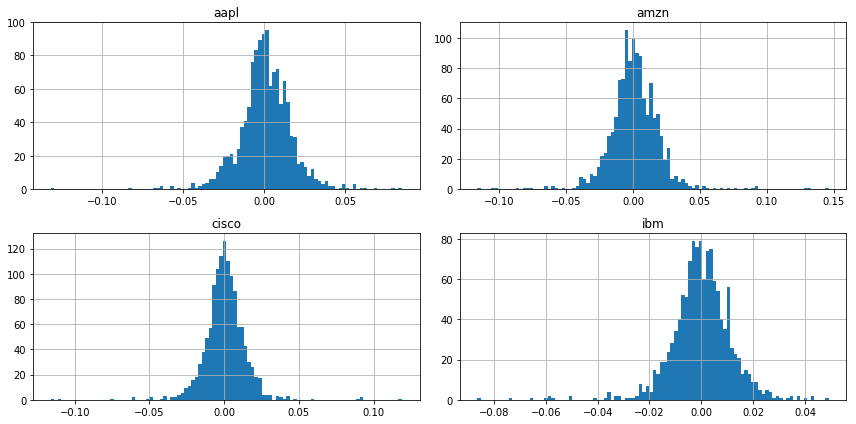

In [9]:
log_ret.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [10]:
log_ret.mean()

aapl     0.000614
cisco    0.000497
ibm      0.000025
amzn     0.001139
dtype: float64

In [12]:
log_ret.cov() * 252

,aapl,cisco,ibm,amzn
aapl,0.068351,0.017864,0.014491,0.019009
cisco,0.017864,0.051395,0.018012,0.019991
ibm,0.014491,0.018012,0.035254,0.014985
amzn,0.019009,0.019991,0.014985,0.094476


In [20]:
np.random.seed(101)

num_ports = 5000
all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    #Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    #Save Weights
    all_weights[ind,:] = weights

    #Expected Return
    ret_arr[ind] = np.sum(log_ret.mean() * weights * 252)

    #Expected Volatility
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))

    #Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]


In [22]:
sharpe_arr.max()

1.0301141394980675

In [23]:
sharpe_arr.argmax()

1420

In [24]:
all_weights[1420,:]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

In [27]:
max_sr_ret = ret_arr[1420]
max_sr_vol = vol_arr[1420]

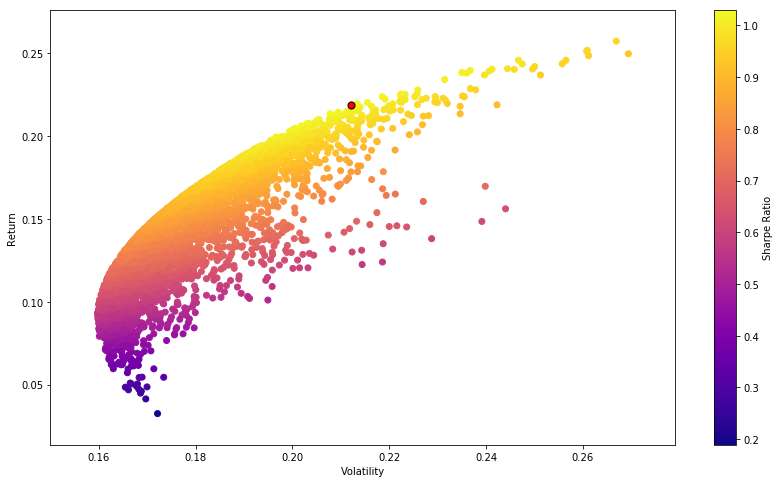

In [28]:
plt.figure(figsize=(14,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

# Mathematical Optimization

In [29]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

To fully understand all the parameters, check out:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

Optimization works as a minimization function, since we actually want to maximize the Sharpe Ratio, we will need to turn it negative so we can minimize the negative sharpe (same as maximizing the postive sharpe)

In [30]:
from scipy.optimize import minimize

In [31]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [32]:
def check_sum(weights):
    #return 0 if the sum of the weights is 1
    return np.sum(weights) - 1

In [35]:
cons = ({'type':'eq','fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [36]:
opt_results

     fun: -1.0304878003708837
     jac: array([ 5.49256802e-05,  3.75956297e-05,  3.23810011e-01, -4.20659781e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.66270326e-01, 2.03917742e-01, 3.15706120e-17, 5.29811932e-01])

In [37]:
opt_results.x

array([2.66270326e-01, 2.03917742e-01, 3.15706120e-17, 5.29811932e-01])

In [38]:
get_ret_vol_sr(opt_results.x)

array([0.21890487, 0.2124284 , 1.0304878 ])

# All Optimal Portfolios (Efficient Frontier)
​
The efficient frontier is the set of optimal portfolios that offers the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal, because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are also sub-optimal, because they have a higher level of risk for the defined rate of return.
​
Efficient Frontier https://www.investopedia.com/terms/e/efficientfrontier.asp

In [39]:
# Our returns go from 0 to somewhere along 0.3 (based on the plot above)
# Create a linspace number of points to calculate x on

frontier_y = np.linspace(0,0.3,100) # Change 100 to a lower number for slower computers!

In [40]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [41]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

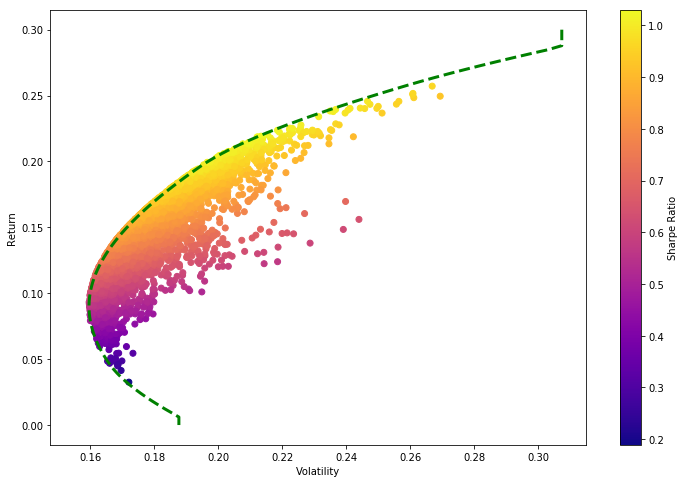

In [42]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

Showing what is you best possible return on indicated volatility